# Models and Evaluation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

train_data = pd.read_csv('../assets/final/data.csv')
test_data = pd.read_csv('../assets/final/kaggleData.csv')

print(train_data.shape)
print(test_data.shape)

(328, 10)
(354, 10)


In [2]:
def get_features(df):
    return df.drop('paid', axis=1)
def get_target(df):
    return df.drop(df.columns.difference(['paid']), axis=1)

results = {}

### Split data

In [3]:
def structure_data():
    ids_train = train_data['loan_id']
    ids_test = test_data['loan_id']

    train_data.drop(['loan_id'], axis=1, inplace=True)
    test_data.drop(['loan_id'], axis=1, inplace=True)

    train_features = get_features(train_data)
    train_target = get_target(train_data)
    test_features = get_features(test_data)
    test_target = get_target(test_data)

    return train_features, test_features, train_target, test_target, ids_train, ids_test


In [4]:
_X_train, _X_test, _y_train, _y_test, ids_train, ids_test = structure_data()

print('\nTrain data shape: ', _X_train.shape)
print('\nTest data shape: ', _X_test.shape)
print('\nTrain shape:',_y_train.shape)
print('\nTest shape:',_y_test.shape)



Train data shape:  (328, 8)

Test data shape:  (354, 8)

Train shape: (328, 1)

Test shape: (354, 1)


### Resampling

In [5]:
def oversample(X_train, y_train):
    from imblearn.over_sampling import SMOTE
    sm = SMOTE(random_state=1, sampling_strategy=1.0)
    X_train, y_train = sm.fit_resample(X_train, y_train)
    return X_train, y_train

In [6]:
_smote_X_train, _smote_y_train = oversample(_X_train, _y_train)

print('\nTrain data shape: ', _smote_X_train.shape)
print('\nTrain shape:',_smote_y_train.shape)



Train data shape:  (564, 8)

Train shape: (564, 1)


### Algorithms

In [7]:
# Trains a specific Model
def add_model(name, model, use_smote=False):
    import datetime
    X_train = _X_train.copy()
    X_test = _X_test.copy()
    smote_X_train = _smote_X_train.copy()

    start = datetime.datetime.now()
    if use_smote: model.fit(smote_X_train, np.ravel(_smote_y_train.values))
    else: model.fit(X_train, np.ravel(_y_train.values))
    end = datetime.datetime.now()

    results[name] = {'model': model,
                    'X_train': X_train, 
                    'X_test': X_test, 
                    'y_train': np.ravel(_y_train.values), 
                    'y_test': np.ravel(_y_test.values),
                    'fit_time': (end - start).microseconds / 1000 # time difference in milliseconds
                    }

In [8]:
USE_SMOTE = False

In [9]:
from sklearn.tree import DecisionTreeClassifier
add_model('dtc',
    DecisionTreeClassifier(),
    use_smote=USE_SMOTE
)

In [10]:
from sklearn.neighbors import KNeighborsClassifier
add_model('knn',
    KNeighborsClassifier(),
    use_smote=USE_SMOTE
)

In [11]:
from sklearn.neural_network import MLPClassifier
add_model('mlp',
    MLPClassifier(),
    use_smote=USE_SMOTE
)

In [12]:
from sklearn.naive_bayes import GaussianNB
add_model('gnb',
    GaussianNB(),
    use_smote=USE_SMOTE
)

In [13]:
from sklearn.svm import SVC
add_model('svc',
    SVC(probability=True),
    use_smote=USE_SMOTE
)

In [14]:
from sklearn.ensemble import RandomForestClassifier

add_model('rf',
    RandomForestClassifier(),#criterion='entropy', max_depth=3, max_features='sqrt', n_estimators=150),
    use_smote=USE_SMOTE
)

## Prediction

# TODO:
- Stratified Cross-Validation
- Check we're SMOTE should be applied
- Test different models
- Clustering

In [15]:
def predict(name, isTrain=False):
    prefix = 'train' if isTrain else 'test'
    result = results[name]
    pred = result['model'].predict(result['X_'+prefix])
    result[prefix+'pred'] = pred

for name in results.keys():
    # Predict paid column on test data
    predict(name)
for name in results.keys():
    # predict paid column on train data
    predict(name, isTrain=True)

In [16]:
def predict_proba(name, isTrain=False):
    prefix = 'train' if isTrain else 'test'
    result = results[name]
    proba = result['model'].predict_proba(result['X_'+prefix])
    result[prefix+'pred_prob'] = proba

for name in results.keys():
    # Predict paid column on test data (Probability)
    predict_proba(name)
for name in results.keys():
    # predict paid column on train data (Probability)
    predict_proba(name, isTrain=True)


In [17]:
# Check result object
'''
testpred -> Prediction of paid column on test data
trainpred -> Prediction of paid column on train data

testpred_prob -> Prediction of Probability of paid column on test data
trainpred_prob -> Prediction of Probability of paid column on train data
'''
# results

'\ntestpred -> Prediction of paid column on test data\ntrainpred -> Prediction of paid column on train data\n\ntestpred_prob -> Prediction of Probability of paid column on test data\ntrainpred_prob -> Prediction of Probability of paid column on train data\n'

### Check Prediction Results

In [18]:
import os

RES_PATH = '../assets/results'
if not os.path.exists(RES_PATH):
  os.mkdir(RES_PATH)

res = {'Id': ids_test.values, 'Predicted': results['rf']['testpred_prob'][:,0]}

df = pd.DataFrame(data=res)
df.to_csv(RES_PATH + '/submission.csv', index=False)

df

,Id,Predicted
0,5895,0.06
1,7122,0.95
2,6173,0.04
3,6142,0.10
4,5358,0.34
...,...,...
349,4989,0.34
350,5221,0.11
351,6402,0.08
352,5346,0.10


In [19]:
print(results['rf']['testpred_prob'])

[[0.06 0.94]
 [0.95 0.05]
 [0.04 0.96]
 [0.1  0.9 ]
 [0.34 0.66]
 [0.07 0.93]
 [0.01 0.99]
 [0.12 0.88]
 [0.12 0.88]
 [0.37 0.63]
 [0.05 0.95]
 [0.05 0.95]
 [0.12 0.88]
 [0.18 0.82]
 [0.02 0.98]
 [0.09 0.91]
 [0.21 0.79]
 [0.02 0.98]
 [0.09 0.91]
 [0.03 0.97]
 [0.19 0.81]
 [0.02 0.98]
 [0.81 0.19]
 [0.05 0.95]
 [0.35 0.65]
 [0.09 0.91]
 [0.17 0.83]
 [0.38 0.62]
 [0.06 0.94]
 [0.05 0.95]
 [0.11 0.89]
 [0.06 0.94]
 [0.05 0.95]
 [0.03 0.97]
 [0.02 0.98]
 [0.02 0.98]
 [0.19 0.81]
 [0.17 0.83]
 [0.14 0.86]
 [0.19 0.81]
 [0.02 0.98]
 [0.46 0.54]
 [0.06 0.94]
 [0.07 0.93]
 [0.17 0.83]
 [0.06 0.94]
 [0.13 0.87]
 [0.   1.  ]
 [0.21 0.79]
 [0.   1.  ]
 [0.83 0.17]
 [0.08 0.92]
 [0.03 0.97]
 [0.17 0.83]
 [0.08 0.92]
 [0.34 0.66]
 [0.05 0.95]
 [0.03 0.97]
 [0.12 0.88]
 [0.06 0.94]
 [0.15 0.85]
 [0.08 0.92]
 [0.06 0.94]
 [0.14 0.86]
 [0.   1.  ]
 [0.11 0.89]
 [0.02 0.98]
 [0.05 0.95]
 [0.27 0.73]
 [0.16 0.84]
 [0.08 0.92]
 [0.09 0.91]
 [0.1  0.9 ]
 [0.45 0.55]
 [0.86 0.14]
 [0.03 0.97]
 [0.16 0.84]

In [20]:
# function that opens RES_PATH + '/submission.csv' and round the Predict table in 1 decimal place
def submission():
  import pandas as pd
  df = pd.read_csv(RES_PATH + '/submission.csv')
  df.to_csv(RES_PATH + '/submission.csv', index=False)

submission()

## Evaluate Prediction with ROC Curve

Submission score: 0.8800411522633745% (~0.88%)


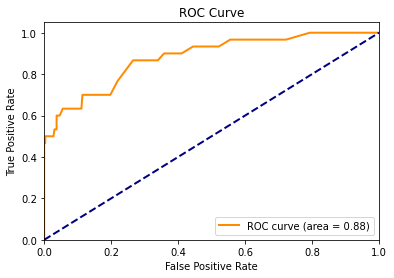

In [21]:
import pandas as pd

SHOW_GRAPH = True

SUBMISSION_PATH = "../assets/results/submission.csv"
RESULTS_PATH = "../assets/complete_clean/loan_dev.csv"

submission_pd = pd.read_csv(SUBMISSION_PATH)
results_pd = pd.read_csv(RESULTS_PATH)
mix_pd = pd.merge(submission_pd, results_pd, left_on='Id', right_on='loan_id', how='inner')

submission_scores = mix_pd["Predicted"].values.tolist()
results = mix_pd["paid"].values.tolist()

fpr, tpr, thresholds = roc_curve(results, submission_scores, pos_label=0)
auc = auc(fpr, tpr)

print(f"Submission score: {auc}% (~{round(auc, 2)}%)")

if SHOW_GRAPH:
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()


---------------------